In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings     
warnings.filterwarnings("ignore")


The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

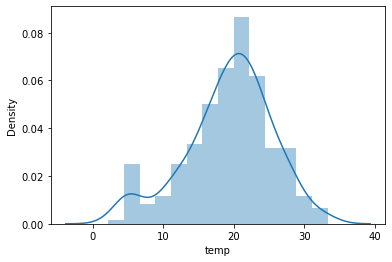

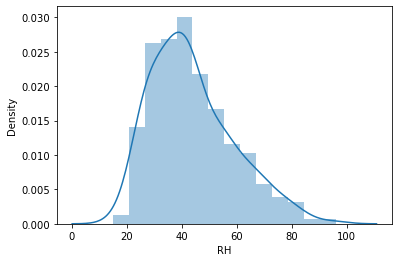

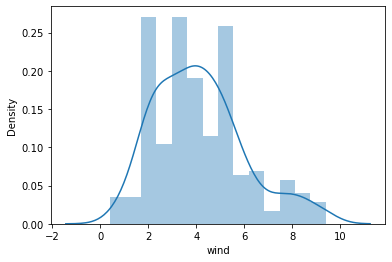

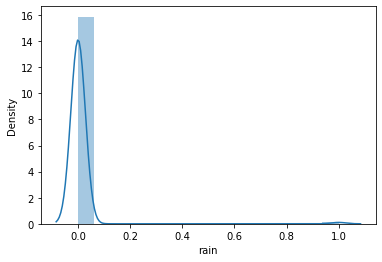

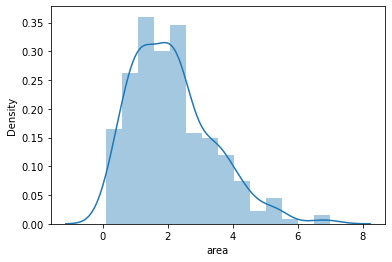

Cluster membership
0    180
1     88
2      2
Name: Cluster_ID, dtype: int64


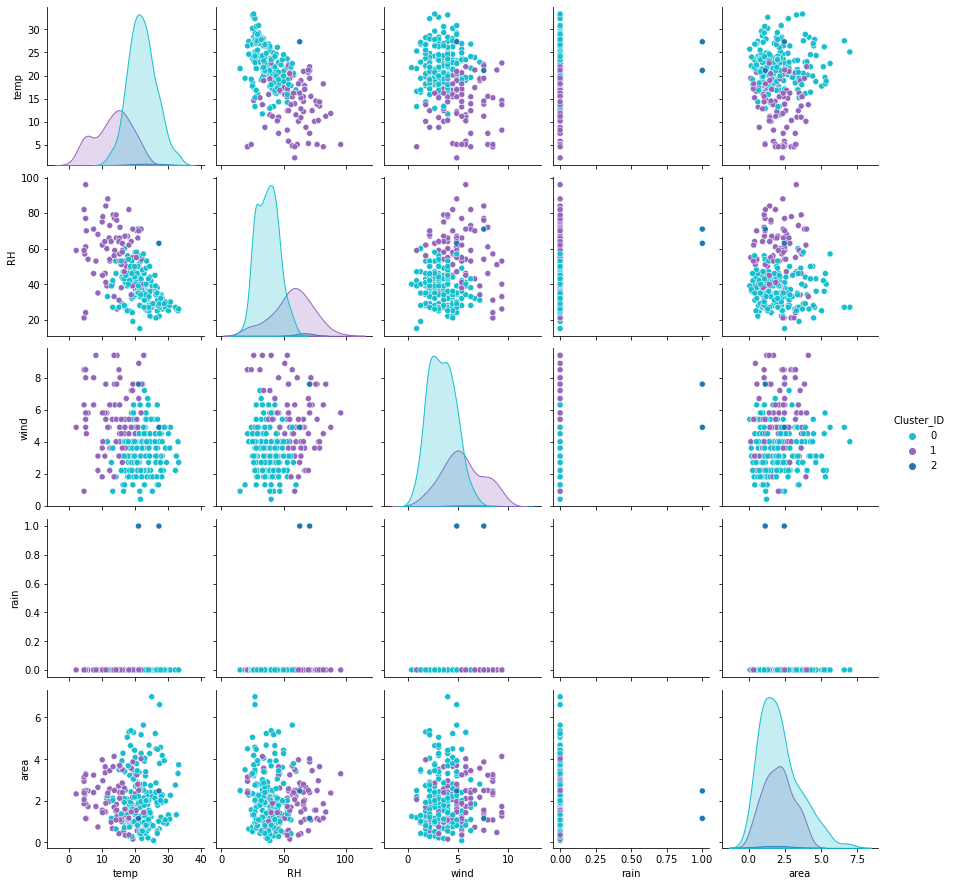

[[-0.212567   -0.11515553 -0.75114458 -0.08638684 -1.45008033]
 [ 0.38730428 -0.38089905 -1.01694934 -0.08638684 -1.4100901 ]
 [ 0.41972976 -0.31446317 -1.22959315 -0.08638684 -1.38810855]
 ...
 [ 1.37628127 -0.77951434 -0.75114458 -0.08638684 -0.09604216]
 [ 0.41972976  1.81148504  0.89684496 -0.08638684  1.50207789]
 [ 0.3062406   1.74504916  1.37529354 -0.08638684  0.29540111]]


In [63]:
# not skipping empty values, to demonstrate data preprocessing steps later
df = pd.read_csv('forestfires.csv', na_filter=False)

columns =['temp', 'RH', 'wind', 'rain', 'area']
df = df[columns]

df = df[df['area']  > 0]

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df_log = df.copy()
columns_to_log_transform = ['area']

for col in columns_to_log_transform:
    df_log[col] = df_log[col].apply(lambda x: x + 1)
    df_log[col] = df_log[col].apply(np.log)
    



# Distribution of RegDens
regdens_dist = sns.distplot(df_log['temp'])
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df_log['RH'])
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df_log['wind'])
plt.show()

meanhhsz_dist = sns.distplot(df_log['rain'])
plt.show()


meanhhsz_dist = sns.distplot(df_log['area'])
plt.show()

# convert df2 to matrix
X = df_log.values

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.cluster import KMeans

# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=rs)
model.fit(X)



# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df_log['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df_log['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_log, hue='Cluster_ID', palette="tab10_r")
plt.show() 

print(X)


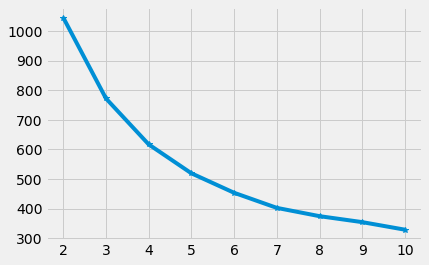

5


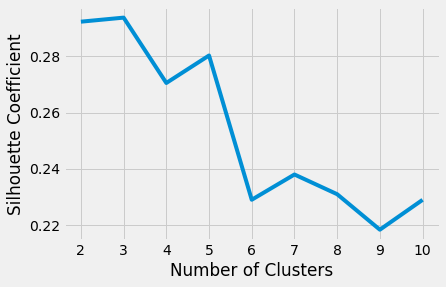

5


In [76]:
# list to save the clusters and cost
clusters = []
inertia_vals = []
silhouette_coefficients = []
from sklearn.metrics import silhouette_score


# this whole process should take a while
for k in range(2, 11):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    silhouette_coefficients.append(score)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

plt.plot(range(2,11), inertia_vals, marker='*')
plt.xticks(range(2, 11))
plt.show()
from kneed import KneeLocator, DataGenerator as dg

kl = KneeLocator(
 range(2, 11), inertia_vals, curve="convex", direction="decreasing"
   )

print(kl.elbow)

# A list holds the silhouette coefficients for each k  
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

print(kl.elbow)


Distribution for cluster 0


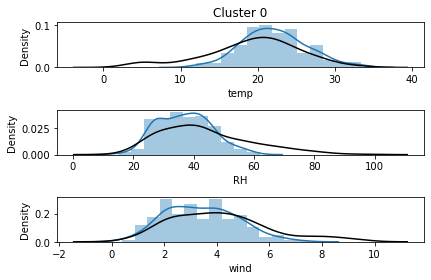

Distribution for cluster 1


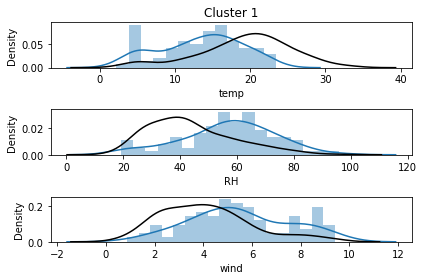

In [67]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['temp', 'RH', 'wind']
n_bins = 20

# inspecting cluster 0 and 1
clusters_to_inspect = [0,1]

for cluster in clusters_to_inspect:
    # inspecting cluster 0
    print("Distribution for cluster {}".format(cluster))

    # create subplots
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        # create the bins
        bins = np.linspace(min(df_log[col]), max(df_log[col]), 20)
        # plot distribution of the cluster using histogram
        sns.distplot(df_log[df_log['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True)
        # plot the normal distribution with a black line
        sns.distplot(df_log[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()

Cluster membership
1    133
0     59
4     43
3     33
2      2
Name: Cluster_ID, dtype: int64


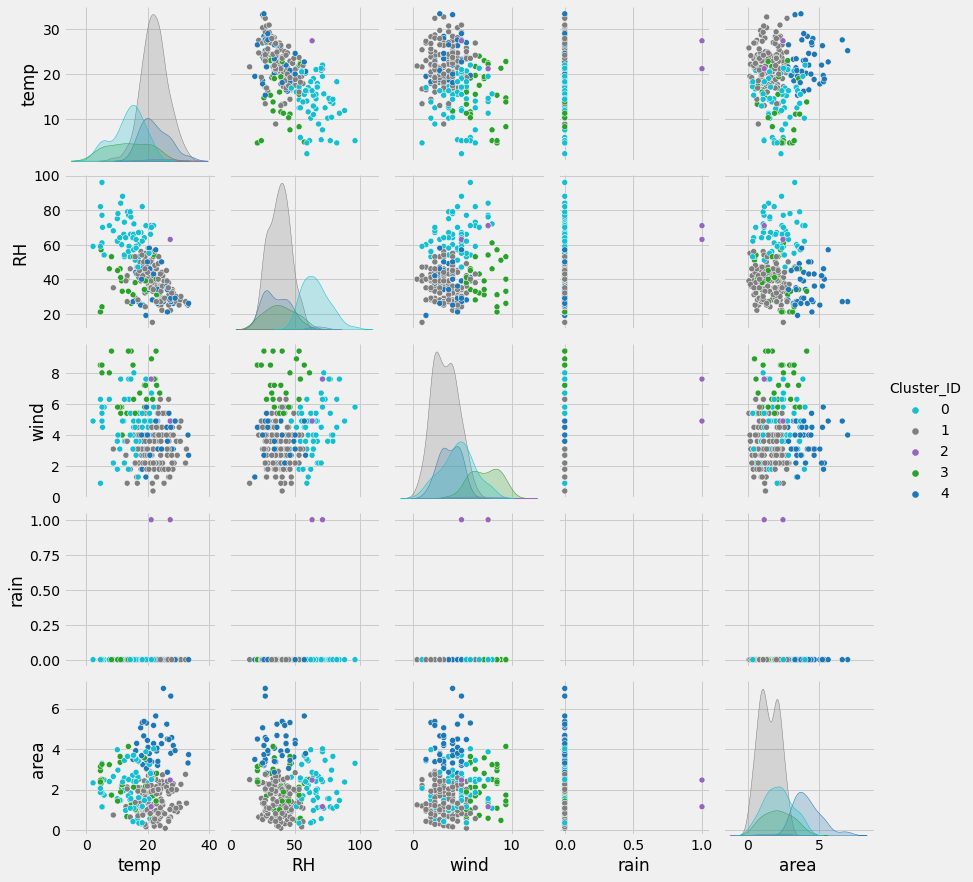

[[-0.212567   -0.11515553 -0.75114458 -0.08638684 -1.45008033]
 [ 0.38730428 -0.38089905 -1.01694934 -0.08638684 -1.4100901 ]
 [ 0.41972976 -0.31446317 -1.22959315 -0.08638684 -1.38810855]
 ...
 [ 1.37628127 -0.77951434 -0.75114458 -0.08638684 -0.09604216]
 [ 0.41972976  1.81148504  0.89684496 -0.08638684  1.50207789]
 [ 0.3062406   1.74504916  1.37529354 -0.08638684  0.29540111]]


In [75]:
# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=5, random_state=rs)
model.fit(X)



# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df_log['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df_log['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_log, hue='Cluster_ID', palette="tab10_r")
plt.show() 

print(X)

The dataset does not have unusual data types and any missing values. 